In [86]:
import numpy
import matplotlib.pyplot as plt

In [87]:
def d8_value(x, y, n = 8):
    alpha = (x == 0).astype(int)
    alpha[alpha == 0] = 2
    alpha = numpy.sqrt(alpha / n)
    return numpy.around(alpha * numpy.cos((numpy.pi * (2 * y + 1) * x) / (2 * n)), 4)


In [88]:
def JD_calcul(image : numpy.ndarray, d8 : numpy.ndarray, around : int = 2) -> numpy.ndarray:
    return numpy.around(d8.dot(image).dot(numpy.linalg.inv(d8)), around)


In [89]:
def case(m, n, table, dim = 8):
    x = numpy.repeat([table[m]], 8, axis=0).T
    y = numpy.repeat([table[n]], 8, axis=0)
    return x * y


In [90]:
def image_state(n : int, JD : numpy.ndarray) -> numpy.ndarray:
    image_partiel = numpy.zeros((8, 8))
    JD_copy = numpy.moveaxis(numpy.abs(JD.copy()), 0, 1)
    replace_min = numpy.min(JD_copy) - 1

    for _ in range(n):
        index = numpy.where(JD_copy == numpy.max(JD_copy))
        y, x = index[0][0], index[1][0]
        image_partiel += case(x, y) * JD[x][y]
        JD_copy[y][x] = replace_min

    return numpy.around(image_partiel)


In [91]:
def show_state(image, state = 1):
    image_partiel = image_state(state)
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap = "gray", vmin = 0, vmax = 255)
    plt.subplot(1, 3, 2)
    plt.imshow(image_partiel, cmap = "gray", vmin = 0, vmax = 255)
    plt.subplot(1, 3, 3)
    plt.imshow(image - image_partiel, cmap = "gray", vmin = -255, vmax = 255)
    print(image - image_partiel)
    plt.show()


In [92]:
def root_mean_square_error(image):
    return numpy.sqrt((image ** 2).sum() / (image.shape[0] * image.shape[1]))

def signal_to_noise_ratio(default, image):
    return 10 * numpy.log10((default ** 2).sum() / ((image ** 2).sum() + 1))


In [93]:
def show_courbe(image):
    x = [k for k in range(64)]
    RSME = [root_mean_square_error(image - image_state(k)) for k in x]
    SNR = [signal_to_noise_ratio(image, image - image_state(k)) for k in x]

    for i in (6, 16, 20, 31, 32):
        print(numpy.around(RSME[i], 1), numpy.around(SNR[i], 1))

    plt.plot(x, RSME, SNR)
    plt.axis([0, 63, 0, 90])
    plt.show()


In [94]:
def DCT(image : numpy.ndarray) -> numpy.ndarray:
    """Return matrices of DCT from image"""
    return JD_calcul(image, numpy.fromfunction(d8_value, shape=(8, 8)))


In [95]:
def image() -> numpy.ndarray:
    """Return image"""
    return numpy.array([
    [52, 55, 61,  66,  70,  61, 64, 73,],
    [63, 59, 55,  90, 109,  85, 69, 72,],
    [62, 59, 68, 113, 144, 104, 66, 73,],
    [63, 58, 71, 122, 154, 106, 70, 69,],
    [67, 61, 68, 104, 126,  88, 68, 70,],
    [79, 65, 60,  70,  77,  68, 58, 75,],
    [85, 71, 64,  59,  55,  61, 65, 83,],
    [87, 79, 69,  68,  65,  76, 78, 94,],
    ])


In [96]:
def coefficient(value : int) -> numpy.ndarray:
    if value > 100 or value < 1:
        value = 50
        print("Value must be between 1 and 100")
    if value < 50:
        alpha = 5000 / value
    else:
        alpha = 200 - 2 * value

    return ((numpy.array([
        [16, 11, 10, 16,  24,  40,  51,  61,],
        [12, 12, 14, 19,  26,  58,  60,  55,],
        [14, 13, 16, 24,  40,  57,  69,  56,],
        [14, 17, 22, 29,  51,  87,  80,  62,],
        [18, 22, 37, 56,  68, 109, 103,  77,],
        [24, 35, 55, 64,  81, 104, 113,  92,],
        [49, 64, 78, 87, 103, 121, 120, 101,],
        [72, 92, 95, 98, 112, 100, 103,  99,],
    ]) * alpha + 50) / 100).astype(int)

In [97]:
def quantized(image : numpy.ndarray, coefficient : numpy.ndarray) -> numpy.ndarray:
    return image/coefficient


In [98]:
def zigzag_ordering(image : numpy.ndarray) -> list[int]:
    def sort(position):
        x, y = position
        return (x + y, -y if (x + y) % 2 else y)
    index = range(image.shape[0])
    zigzag = []
    last = 0
    for index, (x, y) in enumerate(sorted(((x, y) for x in index for y in index), key = sort)):
        zigzag.append(image[x][y])
        if image[x][y] != 0:
            last = index
    return zigzag[:last + 1] + ["EOB"]


In [99]:
def DC(value : int) -> str:
    if value < 0:
        binary = format(-value, "b").replace("1", "2").replace("0", "1").replace("2", "0")
    else:
        binary = format(value, "b")
    return ["010", "011", "100", "00", "101", "110", "1110", "11110", "111110", "1111110", "11111110", "111111110",][len(binary)] + binary


In [100]:
def AC(value : int, run : int = 0) -> str:
    if value == "EOB":
        return "1010"
    if value < 0:
        binary = format(-value, "b").replace("1", "2").replace("0", "1").replace("2", "0")
    else:
        binary = format(value, "b")
    return [
        [          "00",               "01",              "100",             "1011",            "11010",           "111000",          "1111000",       "1111110110", "1111111110000010", "1111111110000011",],
        [        "1100",           "111001",          "1111001",        "111110110",      "11111110110", "1111111110000100", "1111111110000101", "1111111110000110", "1111111110000111", "1111111110001000",],
        [       "11011",         "11111000",       "1111110111", "1111111110001001", "1111111110001010", "1111111110001011", "1111111110001100", "1111111110001101", "1111111110001110", "1111111110001111",],
        [      "111010",        "111110111",       "1111110111", "1111111110010000", "1111111110010001", "1111111110010010", "1111111110010011", "1111111110010100", "1111111110010101", "1111111110010110",],
        [      "111011",       "1111111000", "1111111110010111", "1111111110011000", "1111111110011001", "1111111110011010", "1111111110011011", "1111111110011100", "1111111110011101", "1111111110011110",],
        [     "1111010",       "1111111001", "1111111110011111", "1111111110100000", "1111111110100001", "1111111110100010", "1111111110100011", "1111111110100100", "1111111110100101", "1111111110100110",],
        [     "1111011",      "11111111000", "1111111110100111", "1111111110101000", "1111111110101001", "1111111110101010", "1111111110101011", "1111111110101100", "1111111110101101", "1111111110101110",],
        [    "11111001",      "11111111001", "1111111110101111", "1111111110110000", "1111111110110001", "1111111110110010", "1111111110110011", "1111111110110100", "1111111110110101", "1111111110110110",],
        [    "11111010",  "111111111000000", "1111111110110111", "1111111110111000", "1111111110111001", "1111111110111010", "1111111110111011", "1111111110111100", "1111111110111101", "1111111110111110",],
        [   "111111000", "1111111110111111", "1111111111000000", "1111111111000001", "1111111111000010", "1111111111000011", "1111111111000100", "1111111111000101", "1111111111000110", "1111111111000111",],
        [   "111111001", "1111111111001000", "1111111111001001", "1111111111001010", "1111111111001011", "1111111111001100", "1111111111001101", "1111111111001110", "1111111111001111", "1111111111010000",],
        [   "111111010", "1111111111010001", "1111111111000010", "1111111111010011", "1111111111010100", "1111111111010101", "1111111111010110", "1111111111010111", "1111111111011000", "1111111111011001",],
        [  "1111111010", "1111111111011010", "1111111111011011", "1111111111011100", "1111111111011101", "1111111111011110", "1111111111011111", "1111111111100000", "1111111111100001", "1111111111100010",],
        ["111111110110", "1111111111101100", "1111111111101101", "1111111111101110", "1111111111101111", "1111111111110000", "1111111111110001", "1111111111110010", "1111111111110011", "1111111111110100",],
        ["111111110111", "1111111111110101", "1111111111110110", "1111111111110111", "1111111111111000", "1111111111111001", "1111111111111010", "1111111111111100", "1111111111111101", "1111111111111110",],
    ][run][len(binary) - 1] + binary


In [101]:
def encode(image : list[int], last_value = 0) -> str:
    jpeg = DC(image[0] - last_value)
    count_0 = 0
    for k in image[1:]:
        if k == 0:
            count_0 += 1
        else:
            jpeg += AC(k, count_0)
            count_0 = 0
    return jpeg


In [102]:
print(encode(zigzag_ordering(numpy.around(quantized(DCT(image() - 128), coefficient(16)), 0).astype(int)), -33))

11011001000110000000101001000110001111100010110011010


In [103]:
def extractDC(jpeg : str, last_value : int = 0) -> tuple[list[int], int]:
    index = 1
    DC_code = {
        "010"       : 0,
        "011"       : 1,
        "100"       : 2,
        "00"        : 3,
        "101"       : 4,
        "110"       : 5,
        "1110"      : 6,
        "11110"     : 7,
        "111110"    : 8,
        "1111110"   : 9,
        "11111110"  : 10,
        "111111110" : 11,
    }
    while DC_code.get(jpeg[:index]) is None:
        index += 1
    index_end = index + DC_code.get(jpeg[:index])
    if jpeg[index] == "0":
        return - int(jpeg[index:index_end].replace("1", "2").replace("0", "1").replace("2", "0"), 2) + last_value, index_end
    else:
        return [int(jpeg[index:index_end], 2) + last_value], index_end


In [104]:
def extractAC(jpeg : str, index : int = 0) -> list[int]:
    AC_code = {
        "1010"             : "EOB",

        "00"               : (0, 1),
        "01"               : (0, 2),
        "100"              : (0, 3),
        "1011"             : (0, 4),
        "11010"            : (0, 5),
        "111000"           : (0, 6),
        "1111000"          : (0, 7),
        "1111110110"       : (0, 8),
        "1111111110000010" : (0, 9),
        "1111111110000011" : (0, 10),

        "1100"             : (1, 1),
        "111001"           : (1, 2),
        "1111001"          : (1, 3),
        "111110110"        : (1, 4),
        "11111110110"      : (1, 5),
        "1111111110000100" : (1, 6),
        "1111111110000101" : (1, 7),
        "1111111110000110" : (1, 8),
        "1111111110000111" : (1, 9),
        "1111111110001000" : (1, 10),

        "11011"            : (2, 1),
        "11111000"         : (2, 2),
        "1111110111"       : (2, 3),
        "1111111110001001" : (2, 4),
        "1111111110001010" : (2, 5),
        "1111111110001011" : (2, 6),
        "1111111110001100" : (2, 7),
        "1111111110001101" : (2, 8),
        "1111111110001110" : (2, 9),
        "1111111110001111" : (2, 10),

        "111010"           : (3, 1),
        "111110111"        : (3, 2),
        "1111110111"       : (3, 3),
        "1111111110010000" : (3, 4),
        "1111111110010001" : (3, 5),
        "1111111110010010" : (3, 6),
        "1111111110010011" : (3, 7),
        "1111111110010100" : (3, 8),
        "1111111110010101" : (3, 9),
        "1111111110010110" : (3, 10),

        "111011"           : (4, 1),
        "1111111000"       : (4, 2),
        "1111111110010111" : (4, 3),
        "1111111110011000" : (4, 4),
        "1111111110011001" : (4, 5),
        "1111111110011010" : (4, 6),
        "1111111110011011" : (4, 7),
        "1111111110011100" : (4, 8),
        "1111111110011101" : (4, 9),
        "1111111110011110" : (4, 10),

        "1111010"          : (5, 1),
        "1111111001"       : (5, 2),
        "1111111110011111" : (5, 3),
        "1111111110100000" : (5, 4),
        "1111111110100001" : (5, 5),
        "1111111110100010" : (5, 6),
        "1111111110100011" : (5, 7),
        "1111111110100100" : (5, 8),
        "1111111110100101" : (5, 9),
        "1111111110100110" : (5, 10),

        "1111011"          : (6, 1),
        "11111111000"      : (6, 2),
        "1111111110100111" : (6, 3),
        "1111111110101000" : (6, 4),
        "1111111110101001" : (6, 5),
        "1111111110101010" : (6, 6),
        "1111111110101011" : (6, 7),
        "1111111110101100" : (6, 8),
        "1111111110101101" : (6, 9),
        "1111111110101110" : (6, 10),

        "11111001"         : (7, 1),
        "11111111001"      : (7, 2),
        "1111111110101111" : (7, 3),
        "1111111110110000" : (7, 4),
        "1111111110110001" : (7, 5),
        "1111111110110010" : (7, 6),
        "1111111110110011" : (7, 7),
        "1111111110110100" : (7, 8),
        "1111111110110101" : (7, 9),
        "1111111110110110" : (7, 10),

        "11111010"         : (8, 1),
        "111111111000000"  : (8, 2),
        "1111111110110111" : (8, 3),
        "1111111110111000" : (8, 4),
        "1111111110111001" : (8, 5),
        "1111111110111010" : (8, 6),
        "1111111110111011" : (8, 7),
        "1111111110111100" : (8, 8),
        "1111111110111101" : (8, 9),
        "1111111110111110" : (8, 10),

        "111111000"        : (9, 1),
        "1111111110111111" : (9, 2),
        "1111111111000000" : (9, 3),
        "1111111111000001" : (9, 4),
        "1111111111000010" : (9, 5),
        "1111111111000011" : (9, 6),
        "1111111111000100" : (9, 7),
        "1111111111000101" : (9, 8),
        "1111111111000110" : (9, 9),
        "1111111111000111" : (9, 10),

        "111111001"        : (10, 1),
        "1111111111001000" : (10, 2),
        "1111111111001001" : (10, 3),
        "1111111111001010" : (10, 4),
        "1111111111001011" : (10, 5),
        "1111111111001100" : (10, 6),
        "1111111111001101" : (10, 7),
        "1111111111001110" : (10, 8),
        "1111111111001111" : (10, 9),
        "1111111111010000" : (10, 10),

        "111111010"        : (11, 1),
        "1111111111010001" : (11, 2),
        "1111111111000010" : (11, 3),
        "1111111111010011" : (11, 4),
        "1111111111010100" : (11, 5),
        "1111111111010101" : (11, 6),
        "1111111111010110" : (11, 7),
        "1111111111010111" : (11, 8),
        "1111111111011000" : (11, 9),
        "1111111111011001" : (11, 10),

        "1111111010"       : (12, 1),
        "1111111111011010" : (12, 2),
        "1111111111011011" : (12, 3),
        "1111111111011100" : (12, 4),
        "1111111111011101" : (12, 5),
        "1111111111011110" : (12, 6),
        "1111111111011111" : (12, 7),
        "1111111111100000" : (12, 8),
        "1111111111100001" : (12, 9),
        "1111111111100010" : (12, 10),

        "11111111010"      : (13, 1),
        "1111111111100011" : (13, 2),
        "1111111111100100" : (13, 3),
        "1111111111100101" : (13, 4),
        "1111111111100110" : (13, 5),
        "1111111111101111" : (13, 6),
        "1111111111101000" : (13, 7),
        "1111111111101001" : (13, 8),
        "1111111111101010" : (13, 9),
        "1111111111101011" : (13, 10),

        "111111110110"     : (14, 1),
        "1111111111101100" : (14, 2),
        "1111111111101101" : (14, 3),
        "1111111111101110" : (14, 4),
        "1111111111101111" : (14, 5),
        "1111111111110000" : (14, 6),
        "1111111111110001" : (14, 7),
        "1111111111110010" : (14, 8),
        "1111111111110011" : (14, 9),
        "1111111111110100" : (14, 10),

        "111111110111"     : (15, 1),
        "1111111111110101" : (15, 2),
        "1111111111110110" : (15, 3),
        "1111111111110111" : (15, 4),
        "1111111111111000" : (15, 5),
        "1111111111111001" : (15, 6),
        "1111111111111010" : (15, 7),
        "1111111111111100" : (15, 8),
        "1111111111111101" : (15, 9),
        "1111111111111110" : (15, 10),
    }
    AC = []
    i = index
    while True:
        i += 1
        if AC_code.get(jpeg[index:i]) is None:
            continue
        if AC_code.get(jpeg[index:i]) == "EOB":
            AC.append(AC_code.get(jpeg[index:i]))
            return AC
        index_end = i + AC_code.get(jpeg[index:i])[1]
        for _ in range(AC_code.get(jpeg[index:i])[0]):
            AC.append(0)
        if jpeg[i] == "0":
            AC.append(- int(jpeg[i:index_end].replace("1", "2").replace("0", "1").replace("2", "0"), 2))
        else:
            AC.append(int(jpeg[i:index_end], 2))
        i = index_end
        index = index_end


In [105]:
def extract(jpeg : str, last_value : int = 0) -> list[int]:
    image, index = extractDC(jpeg, last_value)
    image.extend(extractAC(jpeg, index))
    return image


In [106]:
def list_to_zigzag(zigzag : list[int]) -> numpy.ndarray:
    def sort(position):
        x, y = position
        return (x + y, -y if (x + y) % 2 else y)
    index = range(8)
    image = numpy.zeros((8, 8))
    for index, (x, y) in enumerate(sorted(((x, y) for x in index for y in index), key = sort)):
        if zigzag[index] == "EOB":
            break
        image[x][y] = zigzag[index]
    return image

In [107]:
def JDm1_calcul(image : numpy.ndarray, d8 : numpy.ndarray, around : int = 2) -> numpy.ndarray:
    return numpy.around(numpy.linalg.inv(d8).dot(image).dot(d8), around)

[[ 67.28  41.02  37.27  64.57  80.37  71.64  69.95  82.65]
 [ 69.89  49.85  54.8   88.03 103.27  87.59  76.42  82.47]
 [ 69.65  57.93  74.48 115.48 129.7  104.36  80.15  77.1 ]
 [ 65.08  58.02  80.95 125.89 138.77 107.02  74.54  65.8 ]
 [ 64.03  54.1   72.72 114.   125.44  94.68  64.46  57.49]
 [ 76.04  56.13  60.41  90.98 101.09  78.56  60.79  62.78]
 [ 99.24  66.94  53.55  71.18  80.26  68.78  67.25  80.84]
 [118.43  77.71  52.3   61.21  69.74  65.96  75.65  97.25]]


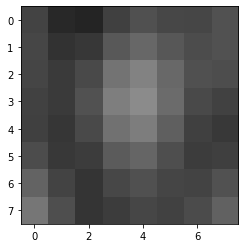

In [108]:
print(JDm1_calcul(list_to_zigzag(extract(encode(zigzag_ordering(numpy.around(quantized(DCT(image() - 128), coefficient(16)), 0).astype(int)), -33), -33)) * coefficient(16),  numpy.fromfunction(d8_value, shape=(8, 8))) + 128)

plt.imshow(JDm1_calcul(list_to_zigzag(extract(encode(zigzag_ordering(numpy.around(quantized(DCT(image() - 128), coefficient(16)), 0).astype(int)), -33), -33)) * coefficient(16),  numpy.fromfunction(d8_value, shape=(8, 8))) + 128, cmap = "gray", vmin = 0, vmax = 255)
